## This notebook is going to use scipy to find the nearest pericentres/apocentres, rather than galpy's methods

In [1]:
from galpy.orbit import Orbit
from galpy.util import conversion
from galpy.potential import MWPotential2014, ChandrasekharDynamicalFrictionForce,HernquistPotential,MovingObjectPotential
from galpy.potential.mwpotentials import McMillan17
import numpy as np
import matplotlib.pyplot as plt

from stream_package.stream_package import graphics

/home/student04/.local/lib/python3.10/site-packages/galpy/util/bovy_conversion.py:6: FutureWarning: galpy.util.bovy_conversion is being deprecated in favor of galpy.util.conversion; all functions in there are the same; please switch to the new import, because the old import will be removed in v1.9
  warnings.warn('galpy.util.bovy_conversion is being deprecated in favor of galpy.util.conversion; all functions in there are the same; please switch to the new import, because the old import will be removed in v1.9',FutureWarning)

/home/student04/.local/lib/python3.10/site-packages/galpy/util/bovy_coords.py:6: FutureWarning: galpy.util.bovy_coords is being deprecated in favor of galpy.util.coords; all functions in there are the same; please switch to the new import, because the old import will be removed in v1.9
  warnings.warn('galpy.util.bovy_coords is being deprecated in favor of galpy.util.coords; all functions in there are the same; please switch to the new import, because the old impo

In [2]:
# Integration of galaxies:
tdisrupt=10

ro = conversion.get_physical(McMillan17)['ro']
vo = conversion.get_physical(McMillan17)['vo']
to = conversion.time_in_Gyr(ro=ro, vo=vo)
mo = conversion.mass_in_msol(ro=ro, vo=vo)
ts = np.linspace(0, -tdisrupt/to, 1001)

pot = McMillan17

o_sats = Orbit.from_name('MW satellite galaxies', ro=ro, vo=vo)
o_sats.integrate(ts, pot)

In [3]:
mass_lmc=1.38e11 #solar masses
rscale_lmc=10.2 #kpc

pot = McMillan17

#Initialize and integrate the orbit of the LMC
#Note orbit has to be integrated back 5 Gyr
#Note we assume the LMC experienced dynamical friction due to MW
o_lmc = Orbit.from_name('LMC', ro=ro, vo=vo, solarmotion=[-11.1, 24.0, 7.25])
ts= np.linspace(0.,-tdisrupt/to,1001)
cdf= ChandrasekharDynamicalFrictionForce(GMs=mass_lmc/mo, rhm=rscale_lmc/ro, dens=pot[1], ro=ro,vo=vo)
o_lmc.integrate(ts,pot+cdf)

#Setup a moving Hernquist potential to represent the LMC
pot_lmc = HernquistPotential(mass_lmc/mo,rscale_lmc/ro,ro=ro,vo=vo)
moving_pot_lmc = MovingObjectPotential(o_lmc, pot_lmc,ro=ro,vo=vo)

#Add the moving Hernquest potential to the MW
total_pot = [pot]
total_pot += [moving_pot_lmc]

In [4]:
from galpy.potential import (evaluateRforces, evaluatephitorques,
                                 evaluatezforces)
loc_origin= 1e-4 # Small offset in R to avoid numerical issues
ax= lambda t: evaluateRforces(moving_pot_lmc,loc_origin,0.,phi=0.,t=t,
                                use_physical=False)
ay= lambda t: evaluatephitorques(moving_pot_lmc,loc_origin,0.,phi=0.,t=t,
                                use_physical=False)/loc_origin
az= lambda t: evaluatezforces(moving_pot_lmc,loc_origin,0.,phi=0.,t=t,
                                use_physical=False)

t_intunits= o_lmc.time(use_physical=False)[::-1] # need to reverse the order for interp
ax4int= np.array([ax(t) for t in t_intunits])
ax_int= lambda t: np.interp(t,t_intunits,ax4int)
ay4int= np.array([ay(t) for t in t_intunits])
ay_int= lambda t: np.interp(t,t_intunits,ay4int)
az4int= np.array([az(t) for t in t_intunits])
az_int= lambda t: np.interp(t,t_intunits,az4int)

from galpy.potential import NonInertialFrameForce
nip= NonInertialFrameForce(a0=[ax_int,ay_int,az_int])

In [5]:
o_sats_LMC = Orbit.from_name('MW satellite galaxies', ro=ro, vo=vo)
o_sats_LMC.integrate(ts, pot + moving_pot_lmc + nip)

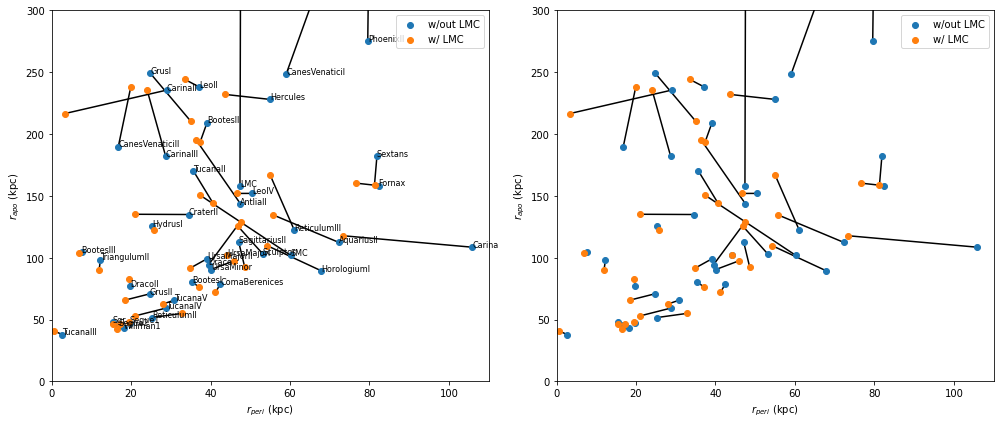

In [6]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

x = np.array([o_sats.rperi(), o_sats_LMC.rperi()])
y = np.array([o_sats.rap(), o_sats_LMC.rap()])

ax1.scatter(o_sats.rperi(), o_sats.rap(), label='w/out LMC')
ax1.scatter(o_sats_LMC.rperi(), o_sats_LMC.rap(), label='w/ LMC')
ax1.plot(x, y, c='k', zorder=0);

ax2.scatter(o_sats.rperi(), o_sats.rap(), label='w/out LMC')
ax2.scatter(o_sats_LMC.rperi(), o_sats_LMC.rap(), label='w/ LMC')
ax2.plot(x, y, c='k', zorder=0);

for i in range(len(o_sats.rperi())):
    name = o_sats.name[i]
    xname, yname = o_sats.rperi()[i], o_sats.rap()[i]
    ax1.annotate(name, (xname,yname), size=8)

ax1.set_xlim(0,110)
ax1.set_ylim(0,300)
ax1.legend()
ax1.set_xlabel('$r_{peri}$ (kpc)', size=10)
ax1.set_ylabel('$r_{apo}$ (kpc)', size=10)

ax2.set_xlim(0,110)
ax2.set_ylim(0,300)
ax2.legend()
ax2.set_xlabel('$r_{peri}$ (kpc)', size=10)
ax2.set_ylabel('$r_{apo}$ (kpc)', size=10)
plt.tight_layout()

In [7]:
#indx = 0.75 < np.divide(o_sats.rperi(),o_sats_LMC.rperi()) or np.divide(o_sats.rap(),o_sats_LMC.rap()) > 1.25
indx1 = np.where(1.25 < np.divide(o_sats.rperi(),o_sats_LMC.rperi()), True, False)
indx2 = np.where(0.75 > np.divide(o_sats.rperi(),o_sats_LMC.rperi()), True, False)
indx3 = np.where(1.25 < np.divide(o_sats.rap(),o_sats_LMC.rap()), True, False)
indx4 = np.where(0.75 > np.divide(o_sats.rap(),o_sats_LMC.rap()), True, False)
indx = indx1 + indx2 + indx3 + indx4


Text(0.5, 1.0, 'Orbital pericentre/apocentre comparison with large (>25%) change')

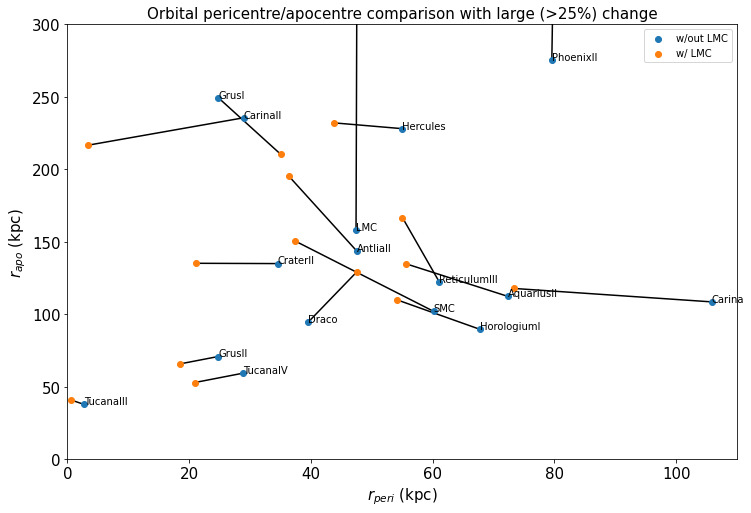

In [8]:
fig = plt.figure(figsize=(12,8))

x = np.array([o_sats.rperi(), o_sats_LMC.rperi()])
y = np.array([o_sats.rap(), o_sats_LMC.rap()])

plt.scatter(o_sats.rperi()[indx], o_sats.rap()[indx], label='w/out LMC')
plt.scatter(o_sats_LMC.rperi()[indx], o_sats_LMC.rap()[indx], label='w/ LMC')
plt.plot(x[:,indx], y[:,indx], c='k', zorder=0);

for i in range(len(o_sats.rperi())):
    if i in np.arange(50)[indx]:
        name = o_sats.name[i]
        xname, yname = o_sats.rperi()[i], o_sats.rap()[i]
        plt.annotate(name, (xname,yname))

plt.xlim(0,110)
plt.ylim(0,300)
plt.legend()
plt.xlabel('$r_{peri}$ (kpc)', size=15)
plt.ylabel('$r_{apo}$ (kpc)', size=15)
plt.xticks(size=15)
plt.yticks(size=15);
plt.title('Orbital pericentre/apocentre comparison with large (>25%) change', size=15)

## Comparing my model pericentre vs. Pace pericentre

In [9]:
import numpy as np
import pandas as pd

data = pd.read_csv(r"summary_table.csv")

In [10]:
peri_LMC = data.pericenter.to_list()
peri_noLMC = data.pericenter_noLMC.to_list()
apo_LMC = data.apocenter.to_list()
apo_noLMC = data.apocenter_noLMC.to_list()
names = data.name.to_list()

names = [s.replace(' ', '') for s in names]

In [11]:
# Find matches between both sets:
matches = list(set(names) & set(o_sats.name))
matches.sort()

In [12]:
#model indexes
indm = np.array([], dtype=bool)
for i in range(len(o_sats.name)):
    if o_sats.name[i] in matches:
        indm = np.append(indm, True)
    else:
        indm = np.append(indm, False)

#data indexes
indd = np.array([], dtype=bool)
for i in range(len(names)):
    if names[i] in matches:
        indd = np.append(indd, True)
    else:
        indd = np.append(indd, False)

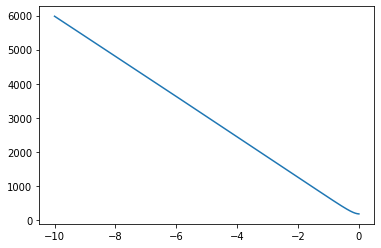

In [46]:
plt.plot(ts*to, o_sats.r(ts)[31])

In [78]:
from scipy.signal import argrelextrema

sat_peri = o_sats.r(ts)[(argrelextrema(o_sats.r(ts), np.less)[0])]
sat_lmc_peri = o_sats_LMC.r(ts)[(argrelextrema(o_sats_LMC.r(ts), np.less)[0])[0]]

sat_ap = o_sats.r(ts)[(argrelextrema(o_sats.r(ts), np.greater)[0])]
sat_lmc_ap = o_sats_LMC.r(ts)[(argrelextrema(o_sats_LMC.r(ts), np.greater)[0])[0]]

sat_peri = []
for i in range(50):
    o = o_sats.r(ts)[i,:]
    m_list = o[(argrelextrema(o, np.less)[0])]
    if m_list.tolist() == []:
        sat_peri.append(0)    #min(o))
    else:
        sat_peri.append(m_list[0])
    
sat_lmc_peri = []
for i in range(50):
    o = o_sats_LMC.r(ts)[i,:]
    m_list = o[(argrelextrema(o, np.less)[0])]
    if m_list.tolist() == []:
        sat_lmc_peri.append(0)   #min(o))
    else:
        sat_lmc_peri.append(m_list[0])
        
sat_ap = []
for i in range(50):
    o = o_sats.r(ts)[i,:]
    m_list = o[(argrelextrema(o, np.greater)[0])]
    if m_list.tolist() == []:
        sat_ap.append(0)    #max(o))
    else:
        sat_ap.append(m_list[0])
        
sat_lmc_ap = []
for i in range(50):
    o = o_sats_LMC.r(ts)[i,:]
    m_list = o[(argrelextrema(o, np.greater)[0])]
    if m_list.tolist() == []:
        sat_lmc_ap.append(0)    #max(o))
    else:
        sat_lmc_ap.append(m_list[0])

In [37]:
#sat_peri = o_sats.rperi().tolist()
#sat_lmc_peri = o_sats_LMC.rperi().tolist()
#sat_ap = o_sats.rap().tolist()
#sat_lmc_ap = o_sats_LMC.rap().tolist()

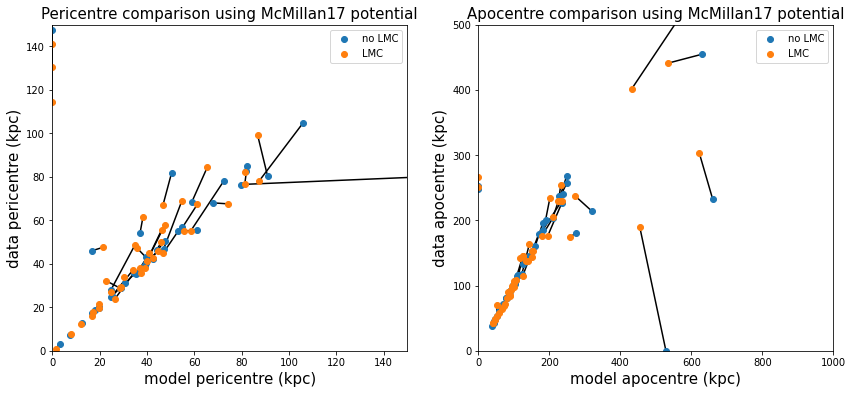

In [79]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

x = np.array([sat_peri, sat_lmc_peri])
y = np.array([peri_noLMC, peri_LMC])

ax1.scatter(np.array(sat_peri)[indm], np.array(peri_noLMC)[indd], label='no LMC')
ax1.scatter(np.array(sat_lmc_peri)[indm], np.array(peri_LMC)[indd], label='LMC')
ax1.plot(x[:,indm], y[:,indd], c='k', zorder=0);

#for i in range(len(sat_peri)):
#    if i in np.arange(50)[indx]:
#        name = o_sats.name[i]
#        xname, yname = sat_peri[i], sat_ap[i]
#        plt.annotate(name, (xname,yname))

ax1.set_xlim(0,150)
ax1.set_ylim(0,150)
ax1.legend()
ax1.set_xlabel('model pericentre (kpc)', size=15)
ax1.set_ylabel('data pericentre (kpc)', size=15)
ax1.set_title('Pericentre comparison using McMillan17 potential', size=15);

x2 = np.array([sat_ap, sat_lmc_ap])
y2 = np.array([apo_noLMC, apo_LMC])

ax2.scatter(np.array(sat_ap)[indm], np.array(apo_noLMC)[indd], label='no LMC')
ax2.scatter(np.array(sat_lmc_ap)[indm], np.array(apo_LMC)[indd], label='LMC')
ax2.plot(x2[:,indm], y2[:,indd], c='k', zorder=0);

ax2.set_xlim(0,1000)
ax2.set_ylim(0,500)
ax2.legend()
ax2.set_xlabel('model apocentre (kpc)', size=15)
ax2.set_ylabel('data apocentre (kpc)', size=15)
ax2.set_title('Apocentre comparison using McMillan17 potential', size=15);


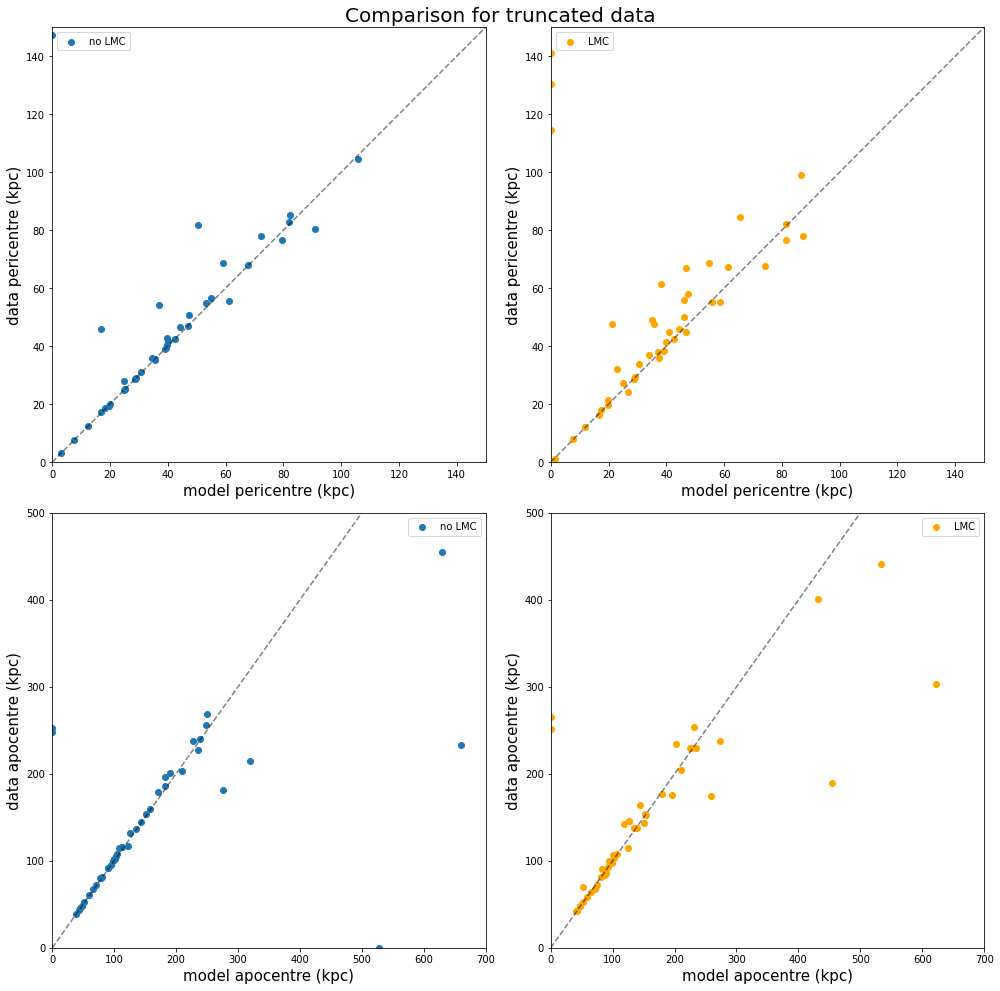

In [80]:
fig = plt.figure(figsize=(14,14))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.scatter(np.array(sat_peri)[indm], np.array(peri_noLMC)[indd], label='no LMC')
ax2.scatter(np.array(sat_lmc_peri)[indm], np.array(peri_LMC)[indd], label='LMC', c='orange')
#for i in range(len(o_sats.rperi())):
#    if i in np.arange(50)[indx]:
#        name = o_sats.name[i]
#        xname, yname = o_sats.rperi()[i], o_sats.rap()[i]
#        plt.annotate(name, (xname,yname))

for ax in [ax1, ax2]:
    ax.set_xlim(0,150)
    ax.set_ylim(0,150)
    ax.legend()
    ax.set_xlabel('model pericentre (kpc)', size=15)
    ax.set_ylabel('data pericentre (kpc)', size=15)
    line = np.linspace(0,150,5)
    ax.plot(line,line, 'k--', alpha=0.5)


ax3.scatter(np.array(sat_ap)[indm], np.array(apo_noLMC)[indd], label='no LMC')
ax4.scatter(np.array(sat_lmc_ap)[indm], np.array(apo_LMC)[indd], label='LMC', c='orange')

for ax in [ax3, ax4]:
    ax.set_xlim(0,700)
    ax.set_ylim(0,500)
    ax.legend()
    ax.set_xlabel('model apocentre (kpc)', size=15)
    ax.set_ylabel('data apocentre (kpc)', size=15)
    line = np.linspace(0,1000,5)
    ax.plot(line,line, 'k--', alpha=0.5)
    
fig.suptitle('Comparison for truncated data', size=20);
plt.tight_layout()

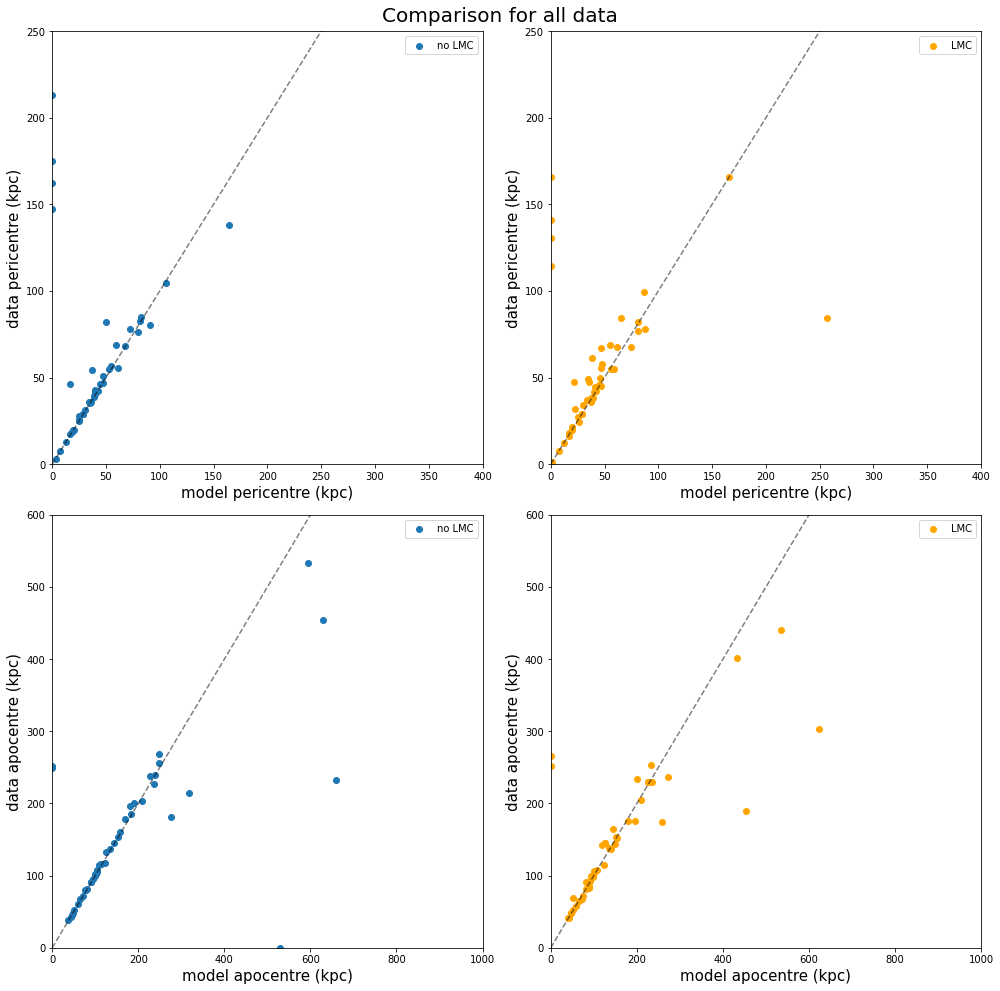

In [82]:
fig = plt.figure(figsize=(14,14))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.scatter(np.array(sat_peri)[indm], np.array(peri_noLMC)[indd], label='no LMC')
ax2.scatter(np.array(sat_lmc_peri)[indm], np.array(peri_LMC)[indd], label='LMC', c='orange')
#for i in range(len(o_sats.rperi())):
#    if i in np.arange(50)[indx]:
#        name = o_sats.name[i]
#        xname, yname = o_sats.rperi()[i], o_sats.rap()[i]
#        plt.annotate(name, (xname,yname))

for ax in [ax1, ax2]:
    ax.set_xlim(0,400)
    ax.set_ylim(0,250)
    ax.legend()
    ax.set_xlabel('model pericentre (kpc)', size=15)
    ax.set_ylabel('data pericentre (kpc)', size=15)
    line = np.linspace(0,400,5)
    ax.plot(line,line, 'k--', alpha=0.5)

ax3.scatter(np.array(sat_ap)[indm], np.array(apo_noLMC)[indd], label='no LMC')
ax4.scatter(np.array(sat_lmc_ap)[indm], np.array(apo_LMC)[indd], label='LMC', c='orange')

for ax in [ax3, ax4]:
    ax.set_xlim(0,1000)
    ax.set_ylim(0,600)
    ax.legend()
    ax.set_xlabel('model apocentre (kpc)', size=15)
    ax.set_ylabel('data apocentre (kpc)', size=15)
    line = np.linspace(0,6000,5)
    ax.plot(line,line, 'k--', alpha=0.5)
    
fig.suptitle('Comparison for all data', size=20);
plt.tight_layout()

## Comparing values in a table:

In [83]:
compare = pd.DataFrame(columns = ['Name', 'Model peri w/o LMC', 'Data peri w/o LMC', 'peri w/o LMC difference',
                                 'Model peri w/ LMC', 'Data peri w/ LMC', 'peri w/ LMC difference',
                                 'Model apo w/o LMC', 'Data apo w/o LMC', 'apo w/o LMC difference',
                                 'Model apo w/ LMC', 'Data apo w/ LMC', 'apo w/ LMC difference'])
compare['Name'] = matches
compare['Model peri w/o LMC'] = np.array(sat_peri)[indm].tolist()
compare['Data peri w/o LMC'] = np.array(peri_noLMC)[indd].tolist()
compare['peri w/o LMC difference'] = compare['Model peri w/o LMC'] - compare['Data peri w/o LMC']

compare['Model peri w/ LMC'] = np.array(sat_lmc_peri)[indm].tolist()
compare['Data peri w/ LMC'] = np.array(peri_LMC)[indd].tolist()
compare['peri w/ LMC difference'] = compare['Model peri w/ LMC'] - compare['Data peri w/ LMC']

compare['Model apo w/o LMC'] = np.array(sat_ap)[indm].tolist()
compare['Data apo w/o LMC'] = np.array(apo_noLMC)[indd].tolist()
compare['apo w/o LMC difference'] = compare['Model apo w/o LMC'] - compare['Data apo w/o LMC']

compare['Model apo w/ LMC'] = np.array(sat_lmc_ap)[indm].tolist()
compare['Data apo w/ LMC'] = np.array(apo_LMC)[indd].tolist()
compare['apo w/ LMC difference'] = compare['Model apo w/ LMC'] - compare['Data apo w/ LMC']

In [84]:
compare

,Name,Model peri w/o LMC,Data peri w/o LMC,peri w/o LMC difference,Model peri w/ LMC,Data peri w/ LMC,peri w/ LMC difference,Model apo w/o LMC,Data apo w/o LMC,apo w/o LMC difference,Model apo w/ LMC,Data apo w/ LMC,apo w/ LMC difference
0,AntliaII,47.516676,50.677523,-3.160847,39.249668,38.162470,1.087198,143.674402,144.724000,-1.049598,139.970349,137.179426,2.790923
1,AquariusII,72.374427,77.916609,-5.542182,58.481258,55.061087,3.420171,112.323616,115.614844,-3.291228,126.907722,145.922915,-19.015193
2,BootesI,35.474410,35.334814,0.139596,37.025198,37.910857,-0.885659,80.339305,80.884500,-0.545195,74.711612,71.744553,2.967058
3,BootesII,39.191768,38.981527,0.210241,37.354716,35.824809,1.529908,209.285914,202.972748,6.313166,179.280339,176.311228,2.969111
4,BootesIII,7.542137,7.474832,0.067305,7.794317,7.806935,-0.012619,104.777983,108.082125,-3.304141,99.151707,97.899179,1.252528
5,CanesVenaticiI,59.066797,68.651572,-9.584774,65.554681,84.511158,-18.956478,248.582910,256.487328,-7.904418,224.995153,229.793691,-4.798538
6,CanesVenaticiII,16.798014,46.020627,-29.222612,21.320741,47.539254,-26.218513,189.653424,201.123495,-11.470071,201.520616,233.975732,-32.455116
7,Carina,105.821322,104.582192,1.239130,87.269744,77.878889,9.390855,108.514753,114.403833,-5.889080,107.246586,108.066181,-0.819595
8,CarinaII,28.989799,28.923005,0.066794,29.158218,29.187787,-0.029569,235.542019,227.056372,8.485647,195.445242,176.049586,19.395656
9,CarinaIII,28.738633,28.724850,0.013783,28.743488,28.755479,-0.011991,182.344851,185.735212,-3.390361,235.260308,230.084492,5.175816
